- [4.1 Overview](#4_1)
- [4.2 Imports and Loading](#4_2)
- [4.3 Preprocessing](#4_3)
- [4.4 Modeling](#4_4)
    - [4.4.1 Linear Regression](#4_4_1)
    - [4.4.2 Logistic Regression](#4_4_2)
    - [4.4.3 Ridge Regression](#4_4_3)
    - [4.4.4 Random Forest](#4_4_4)
    - [4.4.5 SHAP](#4_4_5)
- [4.5 Evaluation](#4_5)

## 4.1 Overview
- We now conduct preprocessing and feature selection to find variables that's important to predicting our job satisfaction (overall_rating)
- Our goal is to use models to define the `correlation` and `drivers` users sentiment have towards their job (overall_rating) based on their rating towards different aspects of their life, the industries and level of management they are in, and based off of their reviews of their jobs

## 4.2 Imports and Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('/Users/Andre/OneDrive/Desktop/1_Glassdoor_Project/CleanedData/clean_data_2.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242755 entries, 0 to 242754
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   industry           242755 non-null  object 
 1   firm               242755 non-null  object 
 2   level              242755 non-null  int64  
 3   job_title          242702 non-null  object 
 4   status             140598 non-null  float64
 5   years              98024 non-null   float64
 6   location           242755 non-null  object 
 7   overall_rating     242755 non-null  int64  
 8   work_life_balance  242755 non-null  float64
 9   culture_values     242755 non-null  float64
 10  career_opp         242755 non-null  float64
 11  comp_benefits      242755 non-null  float64
 12  senior_mgmt        242755 non-null  float64
 13  headline           242755 non-null  object 
 14  pros               242755 non-null  object 
 15  cons               242755 non-null  object 
 16  co

In [3]:
df.head(5)

,industry,firm,level,job_title,status,years,location,overall_rating,work_life_balance,culture_values,...,comp_benefits,senior_mgmt,headline,pros,cons,combined_text,processed_text,word_count,char_count,sentiment_score
0,Retail,ASDA,1,Night Stocker,0.0,1.0,"Glasgow, Scotland, Scotland",3,3.0,2.0,...,3.0,2.0,"Mixed, it very much depends upon the Skills of...",If you live nearby and are physically sound t...,Multi skills or greater performance are not fi...,"Mixed, it very much depends upon the Skills of...",mixed depend Skills Manager seriously absent c...,48,358,0.8692
1,Retail,ASDA,2,Warehouse Operative,1.0,10.0,"London, England, England",5,5.0,5.0,...,5.0,5.0,"very good the freshness,good,support,freedom a...","the freshness,good,support,freedom and attitude",nothing nothing nothing nothing nothing nothing,"very good the freshness,good,support,freedom a...",good freshness good support freedom attitude...,11,88,0.4927
2,Retail,ASDA,2,Availibility,1.0,1.0,"London, England, England",3,3.0,2.0,...,3.0,2.0,"Good company, cares about employees...",Helpful and friendly working environment,Salary is not attractive compare to the curren...,"Good company, cares about employees... Helpful...",good company care employee helpful friendly wo...,13,101,0.8589
3,Retail,ASDA,1,Customer Service Assistant,1.0,5.0,"Glasgow, Scotland, Scotland",3,5.0,4.0,...,2.0,4.0,"Good culture, Great group of people to work wi...","Easy work, good training, 10% off discount car...","Career progression slow, with many people sitt...","Good culture, Great group of people to work wi...",good culture great group people work career pr...,52,353,0.9268
4,Retail,ASDA,1,Checkout Support,1.0,1.0,"Cardiff, Wales, Wales",5,4.0,5.0,...,4.0,5.0,Working in asda,I have felt like i was working among my family...,I can't really think of any .,Working in asda I have felt like i was working...,work asda feel like work family work think,8,42,0.3612


## 4.3 Data Preprocessing
- Make we process all NaN values
- Hot encode/Imput any values if necessary

### 4.3.1 Imputing, NaN Handling, Preparing for training

In [4]:
## Remove job_title rows NA values
## As we looked at in the EDA, status and years has minimal effect on our overall_rating and majority is NaN. We should drop these columns
df.isnull().sum()

industry                  0
firm                      0
level                     0
job_title                53
status               102157
years                144731
location                  0
overall_rating            0
work_life_balance         0
culture_values            0
career_opp                0
comp_benefits             0
senior_mgmt               0
headline                  0
pros                      0
cons                      0
combined_text             0
processed_text            0
word_count                0
char_count                0
sentiment_score           0
dtype: int64

In [5]:
### Also headline, pros, and cons columns have been processed already so we can drop this for our model
### Futhermore, word and char count is insignificant too.
df.dropna(subset=['job_title'], inplace= True)
df.drop(columns=['headline','pros','cons','status','years','word_count','char_count'], inplace = True)

### We are also interested in the industy and level trends,  firm name, job_title, and location can be forgone for our model
df.drop(columns=['firm','job_title','location'], inplace = True)

df.isnull().sum()

industry             0
level                0
overall_rating       0
work_life_balance    0
culture_values       0
career_opp           0
comp_benefits        0
senior_mgmt          0
combined_text        0
processed_text       0
sentiment_score      0
dtype: int64

We don't have any numerical columns in need of imputing, we selected our values before

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242702 entries, 0 to 242754
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   industry           242702 non-null  object 
 1   level              242702 non-null  int64  
 2   overall_rating     242702 non-null  int64  
 3   work_life_balance  242702 non-null  float64
 4   culture_values     242702 non-null  float64
 5   career_opp         242702 non-null  float64
 6   comp_benefits      242702 non-null  float64
 7   senior_mgmt        242702 non-null  float64
 8   combined_text      242702 non-null  object 
 9   processed_text     242702 non-null  object 
 10  sentiment_score    242702 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 22.2+ MB


### 4.3.3 Test/Train Split
- We seperate into X y (train test) groups

In [7]:
# Due to size of dataset, let's use a subset of this massive data set (24000) to see if we can reduce dimensionality, which is still substantial.
df_samp = df.sample(n=24000)

## Subset substantial enough for PCA, efficient calculation/assessment, and smaller size for heavy computational models purposes
X_samp = df_samp.drop(columns=['overall_rating'])
y_samp = df_samp['overall_rating']
X_train_samp, X_test_samp, y_train_samp, y_test_samp = train_test_split(X_samp, y_samp, test_size=0.3, random_state=42)

## Original Dataset
X = df.drop(columns=['overall_rating'])
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 4.3.4 Feature Seperation
- Let's seperate our features into numerical, categorical, and text columns

In [8]:
from sklearn.preprocessing import FunctionTransformer

numerical_features = ['work_life_balance', 'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt','level', 'sentiment_score']
numerical_transformer = StandardScaler()

### Standardize your categorical variable
categorical_features = ['industry',]

### label encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')  #drop first column to handle multi-collinearity issue

# convert sparse input (values + locations) -> dense input
# stick to 1000 features for now, anything beyond that exponentially drives up computing time
text_features = 'processed_text'
text_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        # name, transformer, features
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_pipeline, text_features)
    ]
)

In [9]:
# Check if it's sparse or dense
X_transformed_samp = preprocessor.fit_transform(X_train_samp)
print(type(X_transformed_samp))  #dense, so we can conduct PCA

<class 'numpy.ndarray'>


### 4.4 Dimensionality Analysis
- We will first conduct PCA on a small but substantial sample to observe signs of overfitting and then decide if we need to pursue dimensionality reduction
- Note: We still want to maintain interpretability of our coefficients later on, so not every model will be given PCA.

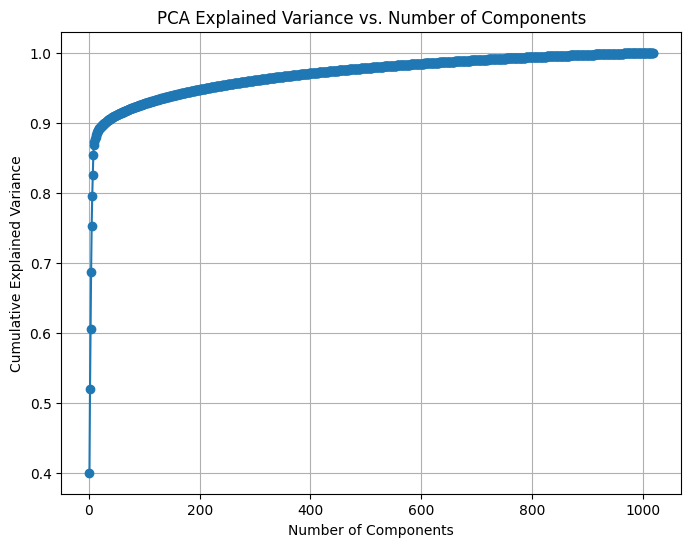

In [10]:
pca = PCA()
## reminder, have to fit again, so fit PCA model to transformed
X_train_pca = pca.fit_transform(X_transformed_samp)

# Calculate the cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

There is most definitley an elbow here, around the 90% variance mark. Every component after offers diminishing variance.

In [11]:
variance_threshold = 0.90
n_components = np.argmax(explained_variance >= variance_threshold) + 1

print(f"Number of components for {variance_threshold*100}% variance: {n_components}")

Number of components for 90.0% variance: 29


I will first train certain models without PCA (linear, logistics) and others (tree) first. Then if needed we will use PCA for lack of computational and interpretability reasons

## 4.5 Model Training

### 4.5.1 Linear Regression
- Let's first conduct a simple linear model to get a better assessment of our models and features

In [12]:
lg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lg_pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(lg_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rsme = np.sqrt(-cv_scores).mean()
print("Cross-validation RMSE:", cv_rsme)

y_pred = lg_pipeline.predict(X_test)

# Calculate RMSE and R² score
# Root Mean Squared Error: measures average magnitude of the errors between predicted values and actual values. Aim for lower RMSE for better fit.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Indicates how well the independent variables explain variability of dependent variable. An R² score of 1 indicates a perfect fit
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse}")
print(f"Linear Regression R²: {r2}")

Cross-validation RMSE: 0.5897571985399084
Linear Regression RMSE: 0.5874297230741212
Linear Regression R²: 0.728269334368677


Let's take a look at our coefficients and see they are alright

In [14]:
coefficients = lg_pipeline.named_steps['regressor'].coef_

# Access feature names
numerical_feature_names = numerical_features
categorical_feature_names = lg_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
text_feature_names = lg_pipeline.named_steps['preprocessor'].transformers_[2][1].named_steps['tfidf'].get_feature_names_out()

all_feature_names = np.concatenate([numerical_feature_names, categorical_feature_names, text_feature_names])

for feature, coef in zip(all_feature_names, coefficients):
    print(f"{feature}: {coef}")


work_life_balance: 0.11524809931521812
culture_values: 0.29041520197980375
career_opp: 0.26403269777422544
comp_benefits: 0.15353633090939725
senior_mgmt: 0.2053255676787344
level: 0.006013026921441567
sentiment_score: 0.0835463551572483
industry_Consumer Goods: 0.09604860252345664
industry_Education: 0.049165248793732054
industry_Financial Services: 0.002718399532200197
industry_Food: 0.09829540963644627
industry_Healthcare: 0.13600521289286782
industry_Hospitality: 0.051189428932486944
industry_Media: -0.0006106538209035284
industry_Pharmaceuticals: 0.005024662775664934
industry_Real Estate: 0.018705759751052903
industry_Retail: 0.12440576764749847
industry_Tech: 0.03557772238387494
industry_Telecommunications: 0.009928651218229875
10: -0.0681998734146617
100: 0.034587365944149184
12: -0.19460271640123797
15: -0.12533981201403563
20: -0.28964045281074946
30: -0.0937606186645802
40: 0.09508268402964154
401: -0.1491302212823593
401k: -0.0962284440660236
50: -0.05797535886648416
ability

Upon inspection, it seems that the hot-encoding labels have generated massive coeffficients. 
- This seems to indicate a problem with multicollinearity, most likely a high variance inflation factor (VIF)

So there's multicollinearity. We now have 2 solutions:
- PCA, but this will not allow us to see our coefficients
- Our good friend Ridge Regression 

### 4.5.2 Ridge Regression, Multicollinearity


In [15]:
lg_ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))  # Alpha: regularization strength
])

lg_ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['work_life_balance',
                                                   'culture_values',
                                                   'career_opp',
                                                   'comp_benefits',
                                                   'senior_mgmt', 'level',
                                                   'sentiment_score']),
                                                 ('cat', OneHotEncoder(),
                                                  ['industry']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=1000)),
                                                                  ('to_dense',
                                                                   FunctionTransformer(accept_sparse=True,
                                                                                       func=<function <lambda> at 0x000001D0ADF63D80>))]),
                                                  'processed_text')])),
                ('regressor', Ridge())])

In [19]:
y_pred = lg_ridge_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Ridge Regression RMSE: {rmse}")
print(f"Ridge Regression R²: {r2}\n")

coefficients = lg_ridge_pipeline.named_steps['regressor'].coef_

for feature, coef in zip(all_feature_names, coefficients):
    print(f"{feature}: {coef}")

Ridge Regression RMSE: 0.5873862009235243
Ridge Regression R²: 0.7283095974482818

work_life_balance: 0.11527052202779488
culture_values: 0.2905998042630132
career_opp: 0.26414786566542026
comp_benefits: 0.1535728466200168
senior_mgmt: 0.20548086479590985
level: 0.00601312572111054
sentiment_score: 0.08355079318985965
industry_Consulting: -0.04826174780855115
industry_Consumer Goods: 0.04778300164186076
industry_Education: 0.0009782981747978373
industry_Financial Services: -0.04557173339675513
industry_Food: 0.05032833068756525
industry_Healthcare: 0.08786888479536756
industry_Hospitality: 0.0030177585685983643
industry_Media: -0.049040121437444024
industry_Pharmaceuticals: -0.04314259438302724
industry_Real Estate: -0.029458786584159544
industry_Retail: 0.0763529934957182
industry_Tech: -0.012730096274207996
industry_Telecommunications: -0.03812418956400924
10: -0.06894830398730455
100: 0.03301030872586258
12: -0.1918414846525054
15: -0.1233691433025352
20: -0.28618144368022125
30: -0

This is a lot more pleasing to look at than before
- Industries don't play a big factor in rating, and have coefficients just as similar as some words

### 4.5.3 Logisitics Ridge Regression
- Now that we are aware of the multicollinearity, we can apply Ridge with logit
- We will conduct it by seperating our overall ratings into 2 categories: 1 (ratings of 5,4) and 0 (3,2,1)

In [21]:
# Convert our values to binary
key = {5: 1, 4: 1, 3: 0, 2: 0, 1: 0}

y_train_log = y_train.map(key)
y_test_log = y_test.map(key)

print(y_train_log.nunique())
print(y_test_log.nunique())

2
2


Accuracy: 0.8690033099394322
Precision: 0.8845954087462345
Recall: 0.9144599789532462
F1 Score: 0.8992798158356038
AUC: 0.8514124033748248


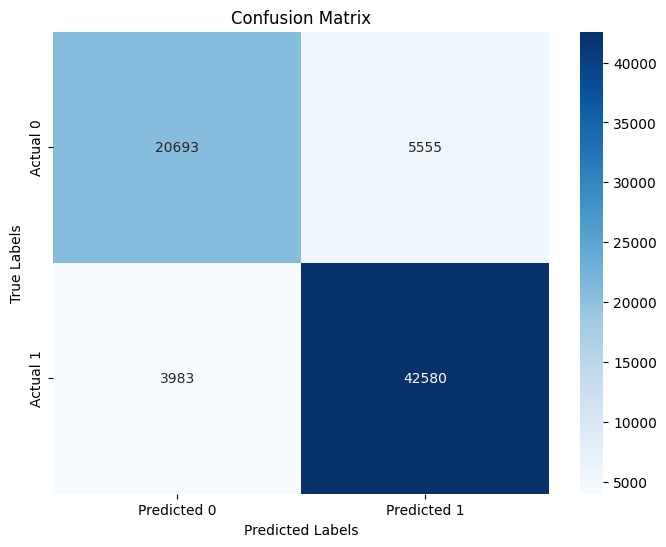

In [26]:
log_ridge_pipeline = Pipeline(steps = [
                        ('preprocessor', preprocessor),
                        # ('logistic', LogisticRegression(max_iter=1000)),
                        ('regressor', LogisticRegression(max_iter=1000, penalty='l2', C=1.0)) , # 'C' is the inverse of regularization strength
                        ])   

### Max iterations, number of times model parameters are alloewd to adjust parameters

log_ridge_pipeline.fit(X_train, y_train_log)

y_pred_log = log_ridge_pipeline.predict(X_test)

accuracy = accuracy_score(y_test_log, y_pred_log)
precision = precision_score(y_test_log, y_pred_log, average='binary')
recall = recall_score(y_test_log, y_pred_log, average='binary')
f1 = f1_score(y_test_log, y_pred_log, average='binary')
auc = roc_auc_score(y_test_log, y_pred_log)
conf_matrix = confusion_matrix(y_test_log, y_pred_log)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

This had a really strong accuracy of 87% and f-1 score of 90% compared to linear
- This may be caused by small discrepancies and subjective approaches and standards for ratings (one persons 5 is another persons 4 etc.)
- Perhaps grouping ratings together this way would help us achieve better predictions results and less margin of error.

### 4.5.4 Random Forest Classifier 
- We will conduct as normal as random forest and other ensemble/boosting techniques is robust against multi-collinearity
- Initially use random search, gridsearch is extremely computationally heavy for this dataset.
- Also we will use our 24000 dataset, running with the full dataset is computationally not possible for personal use laptops

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=45)),
    ('classifier', RandomForestRegressor(random_state=42))
])

rf_param_dist = {
    'classifier__n_estimators': randint(10, 50),  
    'classifier__max_depth': randint(10, 30)       
}

random_search_rf = RandomizedSearchCV(rf_pipeline, param_distributions=rf_param_dist, n_iter=10, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)
random_search_rf.fit(X_train_samp, y_train_samp)  #our set of 24000 datapoints

print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best cross-validation score for Random Forest:", -random_search_rf.best_score_)

best_rf = random_search_rf.best_estimator_ 
y_pred = best_rf.predict(X_test)


Best parameters for Random Forest: {'classifier__max_depth': 11, 'classifier__n_estimators': 97}
Best cross-validation score for Random Forest: 0.3653549463003869


Random forest model does not explain the target variable very well (R² = .365), does not capture patterns in the data
- perhaps we lost too much information in cutting 240000 to 10% of subset?
- We will stick to linear models to explain our understanding of drivers for this project

### 4.5.5 LightGBM classifier
- Light Gradient Boosting Machine
- Once again, we use a sampled subset of data due to computational reasons
- I am also concerned that there may multicollinearity, so I used PCA to see if results are better than random forest

In [14]:
from lightgbm import LGBMRegressor

pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components= .9)),
    ('lgbmregressor', LGBMRegressor(random_state=42))
])

param_grid_lgbm = {
    'lgbmregressor__n_estimators': [100, 200],
    'lgbmregressor__learning_rate': [0.01, 0.1],
    'lgbmregressor__max_depth': [10, 20, -1] #use -1 for unlimited depth, but we will avoid due to lack of computational power
}

grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_lgbm.fit(X_train_samp, y_train_samp)

print("Best parameters for LightGBM:", grid_search_lgbm.best_params_)
print("Best cross-validation score for LightGBM:", -grid_search_lgbm.best_score_)

best_lgbm = grid_search_lgbm.best_estimator_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 26
[LightGBM] [Info] Start training from score 3.734881
Best parameters for LightGBM: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__max_depth': 20, 'lgbmregressor__n_estimators': 100}
Best cross-validation score for LightGBM: 0.35970541012391993


Need to look further into this, something in the model is contriibuting to drastic performance differences between regression and ensemble models
- Preprocessing? Is it possible that tfdif is causing high multidimensionality?

## 4.6 Summary

#### Best Performing Models: 
- Ridge Regression and Logistic Regression
  - Shows strong predictive power and meaningful coefficients that highlight the key drivers of employee satisfaction.
- Ridge Regression Insights: The most impactful features were culture_values and career_opp, suggesting that these are the primary drivers of satisfaction.
- Logistic Regression Performance: Grouping The model accurately classified satisfaction levels with high precision and recall, better accounted for subjectivity in employee ratings

#### Model Challenges: 
- Despite efforts, Random Forest and LightGBM struggled, possibly due to the nature of the data or the preprocessing steps.
- Further investigation would be required to optimize these models or confirm their unsuitability for this dataset.

#### For future iterations: Applying SHAP values instead of looking at coefficients
- Shapley Values: how fairly distribute the "payout" (i.e., the prediction in machine learning) among the features based on their contribution.
- By breaking down a prediction into the contributions of each feature.